# 200721 Locate Identical Signatures

In [1]:
using GZip
using ProgressMeter
using VPTrees
using StatsBase
using DataFrames
using CSV
using CategoricalArrays
using JSON

In [2]:
using Midas
using Midas.Distances
using Midas.SignatureFiles

In [3]:
using PyPlot
using PyCall

sns = pyimport("seaborn")

PyObject <module 'seaborn' from '/Users/student/anaconda/envs/modeling/lib/python3.6/site-packages/seaborn/__init__.py'>

## File paths

In [4]:
taxonomy_file_name = "/Users/student/notebooks/midas/midas-notebooks-2019/build-v1-database/out/3-curated-taxonomy-assignments.csv"
signature_file_name = "/Users/student/projects/midas/data/2019_20/refseq_curated_1.1beta_200604.midas-signatures.gz"
;

In [5]:
out_dir = "../../data/processed/200721-locate-identical-signatures/"
isdir(out_dir) || mkdir(out_dir)

true

In [6]:
table_out = out_dir * "200721-identical-signature-groups.csv"
summary_out = out_dir * "200721-identical-signatures-summary.csv"

"../../data/processed/200721-locate-identical-signatures/200721-identical-signatures-summary.csv"

## Load taxonomy

In [7]:
taxdf = DataFrame(CSV.File(taxonomy_file_name));

In [8]:
sig_genera = categorical(taxdf[!, :genus])
genera = levels(sig_genera)

sig_species = categorical([(row[:genus], row[:species]) for row in eachrow(taxdf)])
species = levels(sig_species)

length(genera), length(species)

(419, 1438)

In [9]:
genus_counts = counts(sig_genera.refs)
species_counts = counts(sig_species.refs)
;

In [10]:
genome_accs = [last(split(k, "/")) for k in taxdf[!, :key]];

## Load signatures

In [11]:
sigfile = SignatureFile(GZip.open(signature_file_name))

SignatureFile{UInt32,GZipStream} with 50752 elements

In [12]:
metadata = SignatureFiles._read_metadata(sigfile.stream, sigfile.header.o_metadata...)
JSON.print(metadata, 2)

{
  "date_created": "2020-06-04",
  "genome_set": {
    "key": "midas/assembly/curated",
    "name": "refseq_curated_2020",
    "meta": {
      "date_created": "2020-05-26",
      "parent": {
        "key": "midas/assembly/curated",
        "key_version": "0.9"
      }
    },
    "description": "Created 2020-05-26 by filtering version 0.9 by inclusion in refseq/assembly/all 1.1",
    "key_version": "1.1"
  },
  "kmer_spec": {
    "k": 11,
    "prefix": "ATGAC"
  },
  "description": "Signatures for version 1.1 of curated genome set"
}


In [13]:
# Should both be sorted:
@assert sigfile.ids == taxdf[:, :key]

In [14]:
@time sigs = collect(SignatureArray(sigfile));

102.168862 seconds (220.86 k allocations: 1.363 GiB, 0.01% gc time)


## Build metric tree

In [15]:
@time tree = VPTree(sigs, jaccard_dist_sorted);

 35.634735 seconds (5.93 M allocations: 288.234 MiB, 0.06% gc time)


## Find groups of identical signatures

In [16]:
id_sets = []  # Sets of indices for identical signatures
id_map = Dict{Int,Any}()  # Map from indices to their sets

@showprogress for (i, sig) in enumerate(sigs)
    haskey(id_map, i) && continue
    
    # Use positive threshold because I'm not sure if distances at exactly threshold are counted correctly...
    # It shouldn't be possible for a distance to be this small and non-zero
    res = Set(find(tree, sig, 1e-10))
    
    @assert length(res) >= 1
    
    if length(res) > 1
        push!(id_sets, res)
        for j in res
            id_map[j] = res
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02m


Turn into a dataframe:

In [17]:
id_df = DataFrame([String, String, Int, Int, String], [:genus, :species, :group_ngenomes, :species_ngenomes, :accs])

for is in id_sets
    sp = only(unique(get(sig_species[i]) for i in is))  # This throws an error if there is more than one species in the group
    spi = findfirst(==(sp), species)
    accs = join(sort([genome_accs[i] for i in is]), ",")
    push!(id_df, (sp..., length(is), species_counts[spi], accs))
end

sort!(id_df, :group_ngenomes; rev=true)

,genus,species,group_ngenomes,species_ngenomes,accs
,String,String,Int64,Int64,String
1,Streptococcus,pneumoniae,135,7099,"GCF_900048815.1,GCF_900049105.1,GCF_900049575.1,GCF_900049585.1,GCF_900049595.1,GCF_900049605.1,GCF_900049615.1,GCF_900049915.1,GCF_900049925.1,GCF_900050355.1,GCF_900050375.1,GCF_900050755.1,GCF_900050765.1,GCF_900050775.1,GCF_900051245.1,GCF_900051485.1,GCF_900051495.1,GCF_900051505.1,GCF_900051525.1,GCF_900051545.1,GCF_900051855.1,GCF_900051875.1,GCF_900051915.1,GCF_900052185.1,GCF_900052215.1,GCF_900052495.1,GCF_900052505.1,GCF_900052785.1,GCF_900053115.1,GCF_900053585.1,GCF_900054065.1,GCF_900054085.1,GCF_900054095.1,GCF_900054245.1,GCF_900054255.1,GCF_900054265.1,GCF_900054275.1,GCF_900054525.1,GCF_900054785.1,GCF_900054795.1,GCF_900054805.1,GCF_900055065.1,GCF_900055085.1,GCF_900055465.1,GCF_900055755.1,GCF_900055765.1,GCF_900055775.1,GCF_900055805.1,GCF_900055815.1,GCF_900055825.1,GCF_900056045.1,GCF_900056055.1,GCF_900056075.1,GCF_900056085.1,GCF_900056095.1,GCF_900056105.1,GCF_900056135.1,GCF_900056445.1,GCF_900056455.1,GCF_900056765.1,GCF_900056775.1,GCF_900056795.1,GCF_900056805.1,GCF_900057035.1,GCF_900057185.1,GCF_900057195.1,GCF_900057215.1,GCF_900057435.1,GCF_900057455.1,GCF_900057665.1,GCF_900057905.1,GCF_900057945.1,GCF_900057975.1,GCF_900058215.1,GCF_900058235.1,GCF_900058445.1,GCF_900058455.1,GCF_900058465.1,GCF_900058675.1,GCF_900059015.1,GCF_900059025.1,GCF_900059035.1,GCF_900059055.1,GCF_900059065.1,GCF_900059385.1,GCF_900059395.1,GCF_900059405.1,GCF_900059715.1,GCF_900059735.1,GCF_900059875.1,GCF_900059885.1,GCF_900060095.1,GCF_900060105.1,GCF_900060115.1,GCF_900060615.1,GCF_900060915.1,GCF_900060925.1,GCF_900060945.1,GCF_900061265.1,GCF_900061295.1,GCF_900061305.1,GCF_900061315.1,GCF_900061325.1,GCF_900061335.1,GCF_900061875.1,GCF_900061885.1,GCF_900062035.1,GCF_900062045.1,GCF_900062185.1,GCF_900062195.1,GCF_900062215.1,GCF_900062225.1,GCF_900062815.1,GCF_900062965.1,GCF_900062975.1,GCF_900062985.1,GCF_900063215.1,GCF_900063225.1,GCF_900063245.1,GCF_900063265.1,GCF_900063525.1,GCF_900063535.1,GCF_900063985.1,GCF_900064005.1,GCF_900064265.1,GCF_900064275.1,GCF_900064955.1,GCF_900064975.1,GCF_900065205.1,GCF_900065365.1,GCF_900065375.1,GCF_900065645.1,GCF_900065655.1,GCF_900065675.1,GCF_900065685.1"
2,Streptococcus,pneumoniae,60,7099,"GCF_900049095.1,GCF_900049935.1,GCF_900050365.1,GCF_900051235.1,GCF_900051515.1,GCF_900051535.1,GCF_900051555.1,GCF_900051885.1,GCF_900051895.1,GCF_900051925.1,GCF_900052195.1,GCF_900052205.1,GCF_900052805.1,GCF_900052815.1,GCF_900053105.1,GCF_900053775.1,GCF_900054075.1,GCF_900055035.1,GCF_900055075.1,GCF_900055095.1,GCF_900055455.1,GCF_900055475.1,GCF_900055745.1,GCF_900055785.1,GCF_900055795.1,GCF_900056065.1,GCF_900056115.1,GCF_900056125.1,GCF_900056155.1,GCF_900056465.1,GCF_900056745.1,GCF_900056755.1,GCF_900056815.1,GCF_900057225.1,GCF_900057465.1,GCF_900057925.1,GCF_900057965.1,GCF_900058205.1,GCF_900059725.1,GCF_900059745.1,GCF_900060085.1,GCF_900060315.1,GCF_900060605.1,GCF_900060625.1,GCF_900060935.1,GCF_900061285.1,GCF_900062055.1,GCF_900062825.1,GCF_900062955.1,GCF_900063005.1,GCF_900063235.1,GCF_900063255.1,GCF_900063505.1,GCF_900063515.1,GCF_900063975.1,GCF_900063995.1,GCF_900064965.1,GCF_900065185.1,GCF_900065195.1,GCF_900065665.1"
3,Salmonella,enterica,55,4650,"GCF_001079785.1,GCF_001085745.1,GCF_001089865.1,GCF_001091845.1,GCF_001092245.1,GCF_001095705.1,GCF_001096485.1,GCF_001096905.1,GCF_001099045.1,GCF_001099705.1,GCF_001115025.1,GCF_001118345.1,GCF_001118425.1,GCF_001119745.1,GCF_001120605.1,GCF_001122965.1,GCF_001126405.1,GCF_001129305.1,GCF_001131765.1,GCF_001138245.1,GCF_001141825.1,GCF_001144045.1,GCF_001146725.1,GCF_001149685.1,GCF_001149885.1,GCF_001155705.1,GCF_001162605.1,GCF_001163925.1,GCF_001166045.1,GCF_001166345.1,GCF_001166585.1,GCF_001168005.1,GCF_001168685.1,GCF_001317625.1,GCF_001328635.1,GCF_001328695.1,GCF_001328815.1,GCF_001356355.1,GCF_001356435.1,GCF_001356455.1,GCF_001356475.1,GCF_001356495.1,GCF_001356515.1,

In [18]:
CSV.write(table_out, id_df)

"../../data/processed/200721-locate-identical-signatures/200721-identical-signature-groups.csv"

Total number of genomes that need to be removed from the database so that only one remains per group:

In [19]:
sum(id_df[!, :group_ngenomes]) - size(id_df, 1)

2213

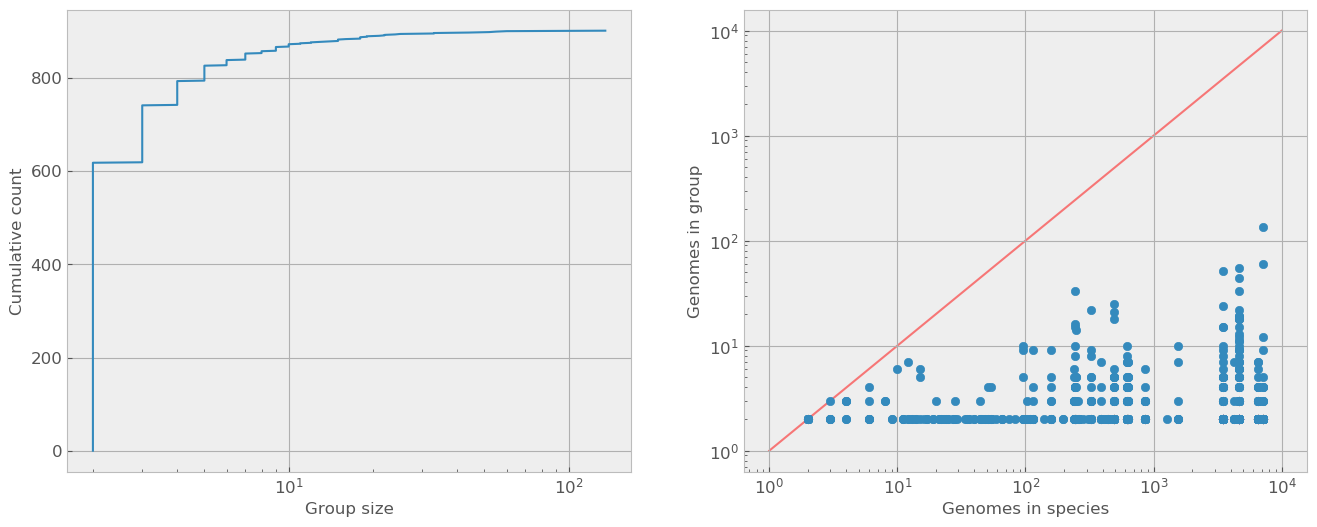

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1a5458c978>

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# axs[1].hist(log10.(id_df[!, :group_ngenomes]), cumulative=true)
axs[1].plot(sort(id_df[!, :group_ngenomes]), 1:size(id_df, 1))
axs[1].set_xscale("log")
axs[1].set_ylabel("Cumulative count")
axs[1].set_xlabel("Group size")

axs[2].scatter(id_df[!, :species_ngenomes], id_df[!, :group_ngenomes])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Genomes in species")
axs[2].set_ylabel("Genomes in group")
axs[2].plot([1, 1e4], [1, 1e4], color="red", alpha=0.5, zorder=-1)

### Summarize by species

In [21]:
function permuterows!(df::DataFrame, p)
    for col in DataFrames._columns(df)
        permute!(col, p)
    end
    return df
end

function sortrows!(df::DataFrame; kw...)
    p = sortperm(eachrow(df); kw...)
    permuterows!(df, p)
    return df
end

sortrows! (generic function with 1 method)

In [22]:
summary_df = DataFrame(
    [String, String, Int, Int, Int, Int],
    [:genus, :species, :ngenomes, :ngroups, :to_remove, :nremaining]
)

for ((gen, sp), sdf) in pairs(groupby(id_df, [:genus, :species]))
    sp_count = species_counts[findfirst(==((gen, sp)), species)]
    ngroups = size(sdf, 1)
    to_remove = sum(sdf[!, :group_ngenomes]) - ngroups
    
    push!(summary_df, (gen, sp, sp_count, ngroups, to_remove, sp_count - to_remove))
end

sortrows!(summary_df, by=r -> (r.nremaining == 1, r.to_remove / r.ngenomes), rev=true)

,genus,species,ngenomes,ngroups,to_remove,nremaining
,String,String,Int64,Int64,Int64,Int64
1,Rickettsia,typhi,3,1,2,1
2,Idiomarina,loihiensis,2,1,1,1
3,Hydrogenobacter,thermophilus,2,1,1,1
4,Lawsonia,intracellularis,2,1,1,1
5,Scardovia,inopinata,2,1,1,1
6,Atopobium,rimae,2,1,1,1
7,Rickettsia,slovaca,2,1,1,1
8,Kinetoplastibacterium,crithidii,2,1,1,1
9,Kinetoplastibacterium,blastocrithidii,2,1,1,1


In [23]:
CSV.write(summary_out, summary_df)

"../../data/processed/200721-locate-identical-signatures/200721-identical-signatures-summary.csv"

Filter to those species which would need to be removed due to having less than two genomes remaining:

In [24]:
summary_df[summary_df[!, :nremaining] .<= 1, :]

,genus,species,ngenomes,ngroups,to_remove,nremaining
,String,String,Int64,Int64,Int64,Int64
1,Rickettsia,typhi,3,1,2,1
2,Idiomarina,loihiensis,2,1,1,1
3,Hydrogenobacter,thermophilus,2,1,1,1
4,Lawsonia,intracellularis,2,1,1,1
5,Scardovia,inopinata,2,1,1,1
6,Atopobium,rimae,2,1,1,1
7,Rickettsia,slovaca,2,1,1,1
8,Kinetoplastibacterium,crithidii,2,1,1,1
9,Kinetoplastibacterium,blastocrithidii,2,1,1,1
